This notebook takes the combined run- and experiment-wide metrics of each sequence-charge, and builds three raw data coordinate estimation models: one each for m/z, RT, and scan.

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,ShuffleSplit,RandomizedSearchCV

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
def GradientBooster(param_grid, n_jobs, X_train, y_train):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
#     classifier = RandomizedSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print('best estimator found by grid search: {}'.format(classifier.best_estimator_))
    return cv, classifier.best_estimator_


In [5]:
file_sequence_charge_attribs_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/file-sequence-charge-attribs-df.pkl')

In [6]:
file_sequence_charge_attribs_df.file_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [7]:
file_idx = 0

#### X is the same for all the estimators

In [8]:
X = file_sequence_charge_attribs_df[file_sequence_charge_attribs_df.file_idx == file_idx][['theoretical_mz','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','experiment_intensity_mean','experiment_intensity_std_dev']].values
y = file_sequence_charge_attribs_df[file_sequence_charge_attribs_df.file_idx == file_idx][['delta_mz_ppm','delta_scan','delta_rt','run_mz','run_scan','run_rt']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

#### m/z delta estimation model - estimate the m/z delta ppm as a proportion of the experiment-wide value

In [9]:
y_train_delta_mz_ppm = y_train[:,0]
y_test_delta_mz_ppm = y_test[:,0]

In [10]:
best_mz_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
# use the best parameters to train the model
best_mz_estimator.fit(X_train, y_train_delta_mz_ppm)
print("R-squared for training set (best model found): {}".format(best_mz_estimator.score(X_train, y_train_delta_mz_ppm)))

R-squared for training set (best model found): 0.9914866459473212


In [12]:
# use the trained model to predict the m/z delta ppm for the test set
y_test_predicted_delta_mz_ppm = best_mz_estimator.predict(X_test)

In [13]:
mz_df = pd.DataFrame()
mz_df['predicted_delta_mz_ppm'] = y_test_predicted_delta_mz_ppm  # the estimated delta
mz_df['delta_rt'] = y_test_delta_mz_ppm  # the actual delta
mz_df['actual_mz'] = y_test[:,3]  # the actual mz
mz_df['experiment_mz'] = X_test[:,0]  # the experiment (theoretical) mz
mz_df['estimated_mz'] = (mz_df.predicted_delta_mz_ppm / 1e6 * mz_df.experiment_mz) + mz_df.experiment_mz
mz_df['error_mz_ppm'] = (mz_df.estimated_mz - mz_df.actual_mz) / mz_df.actual_mz * 1e6

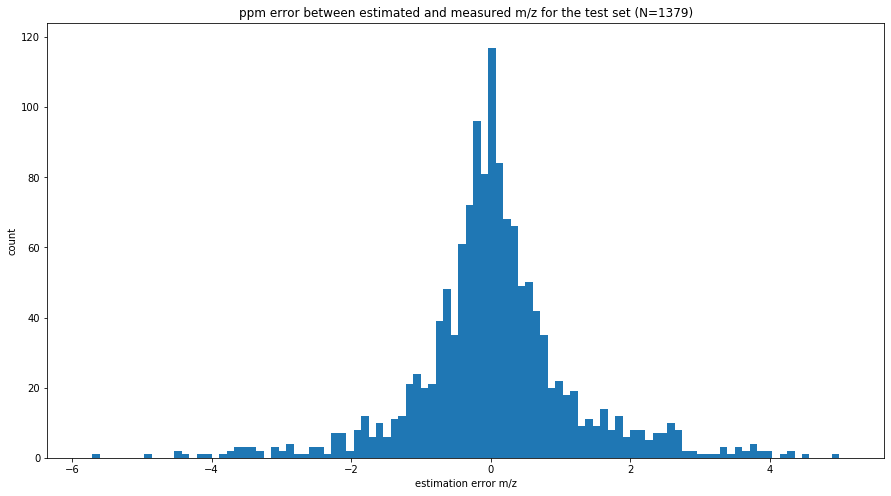

In [14]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('ppm error between estimated and measured m/z for the test set (N={})'.format(len(y_test_predicted_delta_mz_ppm)))

bins = 100
hist, bins, _ = plt.hist(mz_df.error_mz_ppm, bins=bins, label='m/z estimation error')
plt.xlabel('estimation error m/z')
plt.ylabel('count')

plt.show()

In [15]:
# save the trained model
with open('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-0-mz-model.pkl', 'wb') as file:
    pickle.dump(best_mz_estimator, file)

#### scan estimation model - estimate the delta scan as a proportion of the experiment-wide value

In [16]:
y_train_delta_scan = y_train[:,1]
y_test_delta_scan = y_test[:,1]

In [17]:
best_scan_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
# use the best parameters to train the model
best_scan_estimator.fit(X_train, y_train_delta_scan)
print("R-squared for training set (best model found): {}".format(best_scan_estimator.score(X_train, y_train_delta_scan)))

R-squared for training set (best model found): 0.9992386462637352


In [19]:
# use the trained model to predict the scan for the test set
y_test_predicted_delta_scan = best_scan_estimator.predict(X_test)

In [20]:
scan_df = pd.DataFrame()
scan_df['predicted_delta_scan'] = y_test_predicted_delta_scan
scan_df['delta_scan'] = y_test_delta_scan
scan_df['actual_scan'] = y_test[:,4]
scan_df['experiment_scan'] = X_test[:,3]
scan_df['estimated_scan'] = (scan_df.predicted_delta_scan * scan_df.experiment_scan) + scan_df.experiment_scan
scan_df['error_scan'] = scan_df.estimated_scan - scan_df.actual_scan

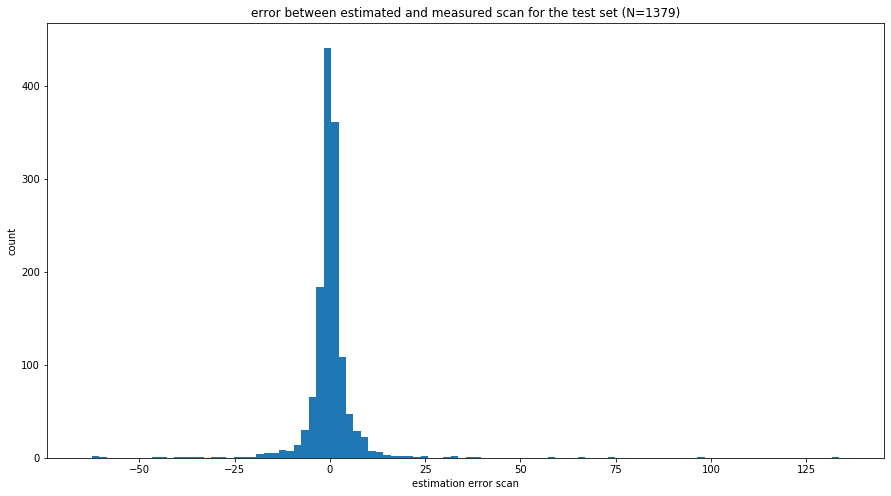

In [21]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('error between estimated and measured scan for the test set (N={})'.format(len(y_test_predicted_delta_scan)))

bins = 100
hist, bins, _ = plt.hist(scan_df.error_scan, bins=bins, label='scan error')
plt.xlabel('estimation error scan')
plt.ylabel('count')

plt.show()

In [22]:
# save the trained model
with open('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-0-scan-model.pkl', 'wb') as file:
    pickle.dump(best_scan_estimator, file)

#### RT estimation model - estimate the RT delta as a proportion of the experiment-wide value

In [23]:
y_train_delta_rt = y_train[:,2]
y_test_delta_rt = y_test[:,2]

In [24]:
best_rt_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
# use the best parameters to train the model
best_rt_estimator.fit(X_train, y_train_delta_rt)
print("R-squared for training set (best model found): {}".format(best_rt_estimator.score(X_train, y_train_delta_rt)))

R-squared for training set (best model found): 0.9985929107829619


In [26]:
# use the trained model to predict the scan for the test set
y_test_predicted_delta_rt = best_rt_estimator.predict(X_test)

In [27]:
rt_df = pd.DataFrame()
rt_df['predicted_delta_rt'] = y_test_predicted_delta_rt
rt_df['delta_rt'] = y_test_delta_rt
rt_df['actual_rt'] = y_test[:,5]
rt_df['experiment_rt'] = X_test[:,1]
rt_df['estimated_rt'] = (rt_df.predicted_delta_rt * rt_df.experiment_rt) + rt_df.experiment_rt
rt_df['error_rt'] = rt_df.estimated_rt - rt_df.actual_rt

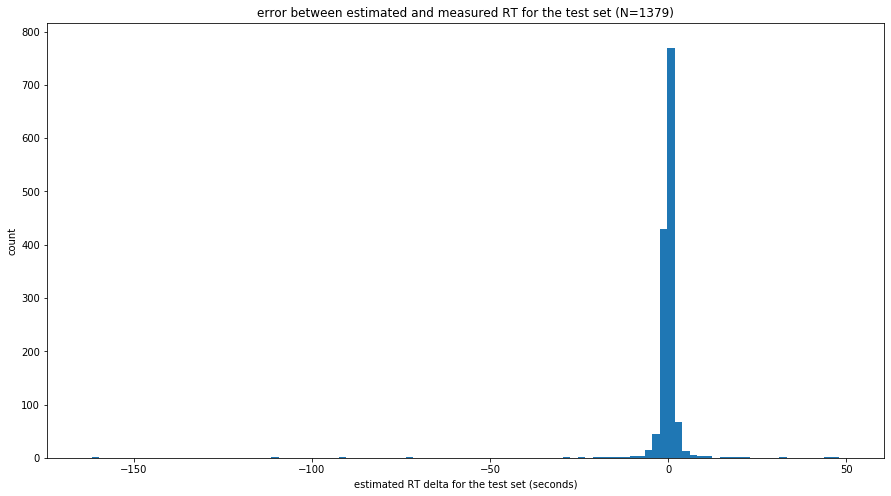

In [28]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('error between estimated and measured RT for the test set (N={})'.format(len(y_test_predicted_delta_rt)))

bins = 100
hist, bins, _ = plt.hist(rt_df.error_rt, bins=bins, label='RT error')
plt.xlabel('estimated RT delta for the test set (seconds)')
plt.ylabel('count')

plt.show()

In [29]:
# save the trained model
with open('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-0-rt-model.pkl', 'wb') as file:
    pickle.dump(best_rt_estimator, file)